In [40]:
!pip install --quiet ultralytics opencv-python matplotlib

In [41]:
from ultralytics import YOLO

In [80]:
import json, random, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [42]:
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))



GPU available: True
GPU name: Tesla T4


In [43]:
!pip install Path

In [44]:
from pathlib import Path
IMAGES_DIR = Path("/kaggle/input/manga109/images")   # các subfolder từng bộ truyện
ANNOTATIONS_DIR = Path("/kaggle/input/manga109/jsons") 

In [47]:
# 1. Paths & logging
# =========================
yolo_data_dir = Path("./yolo_data")
train_images_dir = yolo_data_dir / "images/train"
val_images_dir   = yolo_data_dir / "images/val"
train_labels_dir = yolo_data_dir / "labels/train"
val_labels_dir   = yolo_data_dir / "labels/val"

for path in [train_images_dir, val_images_dir, train_labels_dir, val_labels_dir]:
    path.mkdir(parents=True, exist_ok=True)

IMAGES_DIR = Path("/kaggle/input/manga109-images/images")  # images dataset
ANNOTATIONS_DIR = Path("/kaggle/input/manga109-jsons/jsons")  # COCO JSONs

def log(msg):
    print(f"[INFO] {msg}")


In [48]:
# =========================
# 4. Lấy danh sách JSON & check
# =========================
json_files = list(ANNOTATIONS_DIR.rglob("*.json"))
log(f"Found {len(json_files)} JSON files")
assert len(json_files) > 0, f"No JSON files found in {ANNOTATIONS_DIR}"


[INFO] Found 109 JSON files


In [65]:
# 2. Parse JSON → polygon YOLO .txt (class_id=0)
# =========================
target_class_id = 5  # chỉ dùng class id=5
target_class_name = None

all_image_paths = []
all_label_paths = []

json_files = list(ANNOTATIONS_DIR.glob("*.json"))
assert len(json_files) > 0, "Không tìm thấy file JSON!"

for json_file in json_files:
    with open(json_file, 'r', encoding='utf-8') as f:
        coco = json.load(f)
        # lấy tên class id=5
        if target_class_name is None:
            for c in coco['categories']:
                if c['id'] == target_class_id:
                    target_class_name = c['name']
                    break
        # map image id → file_name
        images_dict = {img['id']: img['file_name'] for img in coco['images']}
        # annotations class id=5
        for ann in coco['annotations']:
            if ann['category_id'] != target_class_id:
                continue
            img_file_name = images_dict[ann['image_id']]
            img_path = IMAGES_DIR / Path(json_file.stem) / img_file_name
            if not img_path.exists():
                log(f"[WARN] Image not found: {img_path}")
                continue

            # Tạo label path
            label_dir = train_labels_dir / Path(json_file.stem)  # tạm train, sau sẽ shuffle
            label_dir.mkdir(parents=True, exist_ok=True)
            label_path = label_dir / (img_path.stem + ".txt")

            # Polygon points normalized
            seg = ann['segmentation']  # list of lists
            lines = []
            for poly in seg:
                coords = np.array(poly).reshape(-1, 2)
                h, w = ann.get('height', 1), ann.get('width', 1)
                # nếu height/width không có trong annotation, lấy từ image
                if h == 1 or w == 1:
                    im = cv2.imread(str(img_path))
                    h, w = im.shape[:2]
                coords[:,0] /= w
                coords[:,1] /= h
                coords = coords.flatten()
                coords_str = " ".join([f"{x:.6f}" for x in coords])
                lines.append(f"0 {coords_str}")  # class_id=0
            # write YOLO polygon txt
            label_path.write_text("\n".join(lines))

            all_image_paths.append(img_path)
            all_label_paths.append(label_path)

log(f"Total images with labels: {len(all_image_paths)}")

[INFO] Total images prepared: 10130
[INFO] Train images total: 8104
[INFO] Val images total: 2026
[INFO] Train labels total: 8104
[INFO] Val labels total: 2026


In [ ]:
# 2. Parse JSON → polygon YOLO .txt (class_id=0) với tracking
target_class_id = 5  # chỉ dùng class id=5
target_class_name = None

all_image_paths = []
all_label_paths = []

json_files = list(ANNOTATIONS_DIR.glob("*.json"))
assert len(json_files) > 0, "Không tìm thấy file JSON!"

total_annotations = 0
total_images = 0

for json_file in json_files:
    with open(json_file, 'r', encoding='utf-8') as f:
        coco = json.load(f)
        # lấy tên class id=5
        if target_class_name is None:
            for c in coco['categories']:
                if c['id'] == target_class_id:
                    target_class_name = c['name']
                    break
        # map image id → file_name
        images_dict = {img['id']: img['file_name'] for img in coco['images']}
        # annotations class id=5
        for ann in coco['annotations']:
            if ann['category_id'] != target_class_id:
                continue
            img_file_name = images_dict[ann['image_id']]
            img_path = IMAGES_DIR / Path(json_file.stem) / img_file_name
            if not img_path.exists():
                log(f"[WARN] Image not found: {img_path}")
                continue

            # Tạo label path
            label_dir = train_labels_dir / Path(json_file.stem)  # tạm train, sau sẽ shuffle
            label_dir.mkdir(parents=True, exist_ok=True)
            label_path = label_dir / (img_path.stem + ".txt")

            # Polygon points normalized
            seg = ann['segmentation']  # list of lists
            lines = []
            for poly in seg:
                coords = np.array(poly).reshape(-1, 2)
                h, w = ann.get('height', 1), ann.get('width', 1)
                # nếu height/width không có trong annotation, lấy từ image
                if h == 1 or w == 1:
                    im = cv2.imread(str(img_path))
                    h, w = im.shape[:2]
                coords[:,0] /= w
                coords[:,1] /= h
                coords = coords.flatten()
                coords_str = " ".join([f"{x:.6f}" for x in coords])
                lines.append(f"0 {coords_str}")  # class_id=0

            # write YOLO polygon txt
            label_path.write_text("\n".join(lines))

            # Track progress
            total_annotations += len(lines)
            total_images += 1
            log(f"[INFO] Parsed image {total_images}: {img_file_name}, polygons: {len(lines)}")

            all_image_paths.append(img_path)
            all_label_paths.append(label_path)

log(f"[INFO] Total images with labels: {len(all_image_paths)}")
log(f"[INFO] Total polygons: {total_annotations}")


In [ ]:
combined = list(zip(all_image_paths, all_label_paths))
random.seed(42)
random.shuffle(combined)
split_idx = int(len(combined) * 0.8)
train_set = combined[:split_idx]
val_set   = combined[split_idx:]

def copy_set(data_set, img_dest_root, label_dest_root):
    for img_path, label_path in data_set:
        subfolder = img_path.parent.name
        img_dest = img_dest_root / subfolder
        label_dest = label_dest_root / subfolder
        img_dest.mkdir(parents=True, exist_ok=True)
        label_dest.mkdir(parents=True, exist_ok=True)
        shutil.copy(str(img_path), str(img_dest / img_path.name))
        shutil.copy(str(label_path), str(label_dest / label_path.name))

copy_set(train_set, train_images_dir, train_labels_dir)
copy_set(val_set, val_images_dir, val_labels_dir)

log(f"Train images total: {sum(len(list(f.iterdir())) for f in train_images_dir.iterdir() if f.is_dir())}")
log(f"Val images total: {sum(len(list(f.iterdir())) for f in val_images_dir.iterdir() if f.is_dir())}")

[INFO] Sample image path: yolo_data/images/train/Ningyoushi/008.jpg


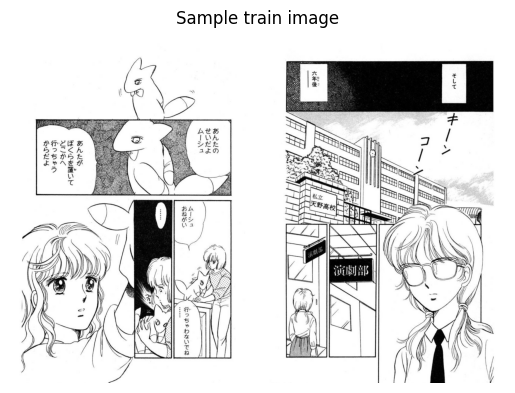

[INFO] Sample label content:
0 0.765719 0.154701 0.417775 0.143590
0 0.737001 0.382479 0.372430 0.311966
0 0.251209 0.357265 0.393591 0.213675
0 0.290508 0.704274 0.071947 0.449573
0 0.390266 0.704274 0.109432 0.449573
0 0.132709 0.739744 0.237606 0.515385
0 0.847037 0.745726 0.207981 0.500000
0 0.597944 0.737607 0.078597 0.379487
0 0.692563 0.737607 0.096131 0.377778
1 0.357618 0.527350 0.034462 0.083761
1 0.397521 0.310256 0.056227 0.094017
1 0.892987 0.142735 0.015719 0.059829
1 0.610943 0.138462 0.024788 0.063248
1 0.106106 0.370085 0.087666 0.133333
1 0.354293 0.849573 0.020556 0.145299
2 0.268440 0.299573 0.124547 0.093162
2 0.406288 0.660684 0.024184 0.039316
2 0.300484 0.823932 0.035067 0.061538
2 0.305018 0.749145 0.029625 0.069231
2 0.262394 0.126923 0.068924 0.100000
2 0.852781 0.718376 0.133615 0.171795
2 0.120919 0.761966 0.124547 0.176923
3 0.300484 0.160256 0.143894 0.182051
3 0.589480 0.827778 0.059250 0.194017
3 0.299879 0.774359 0.053204 0.271795
3 0.136336 0.769231 0

In [69]:
# 4. Create dataset YAML
# =========================
import yaml
dataset_yaml = yolo_data_dir / "dataset.yaml"
yaml_dict = {
    "path": str(yolo_data_dir),
    "train": "images/train",
    "val": "images/val",
    "nc": 1,
    "names": [target_class_name]
}
with open(dataset_yaml, "w") as f:
    yaml.dump(yaml_dict, f, sort_keys=False)
log(f"Dataset YAML created at: {dataset_yaml} with class: {target_class_name}")



In [74]:
model = YOLO("yolov8n-seg.pt")  # pretrained seg model

results = model.train(
    data=str(dataset_yaml),
    epochs=50,
    imgsz=640,
    batch=8,
    device=0,  # GPU
    name="manga_bubble_seg",
    verbose=True
)


[INFO] [INFO] YAML file created at: yolo_data/dataset.yaml with 1 class: balloon


In [ ]:
# =========================
# 7. Evaluate on validation set
# =========================
val_results = model.val(
    data=str(dataset_yaml),
    batch=8,
    imgsz=640
)

# val_results chứa các metrics
print("Validation metrics:")
print(f"mAP50: {val_results.metrics.mAP_50:.4f}")
print(f"mAP50-95: {val_results.metrics.mAP_50_95:.4f}")
print(f"Precision: {val_results.metrics.precision:.4f}")
print(f"Recall: {val_results.metrics.recall:.4f}")


In [ ]:
import matplotlib.pyplot as plt

mask_mAP50 = [x['metrics/mAP50'] for x in results.history]
mask_mAP5095 = [x['metrics/mAP50-95'] for x in results.history]

plt.plot(mask_mAP50, label='mAP50')
plt.plot(mask_mAP5095, label='mAP50-95')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Mask mAP")
plt.legend()
plt.show()
